# Sprint 1: Formalización del problema

## Espacio de codificación de soluciones


Número de autores en el grafo: 1843
Número de aristas en el grafo: 3215


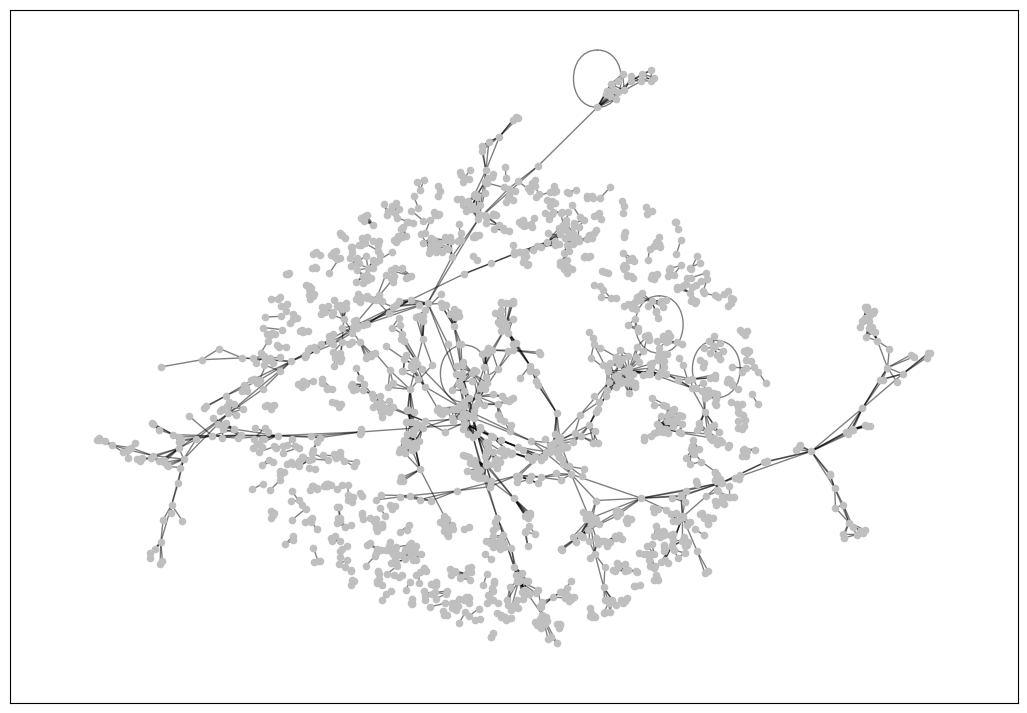

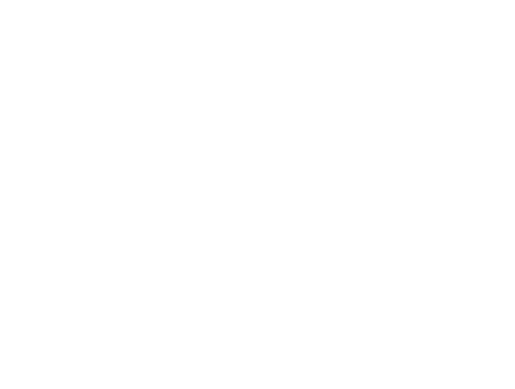

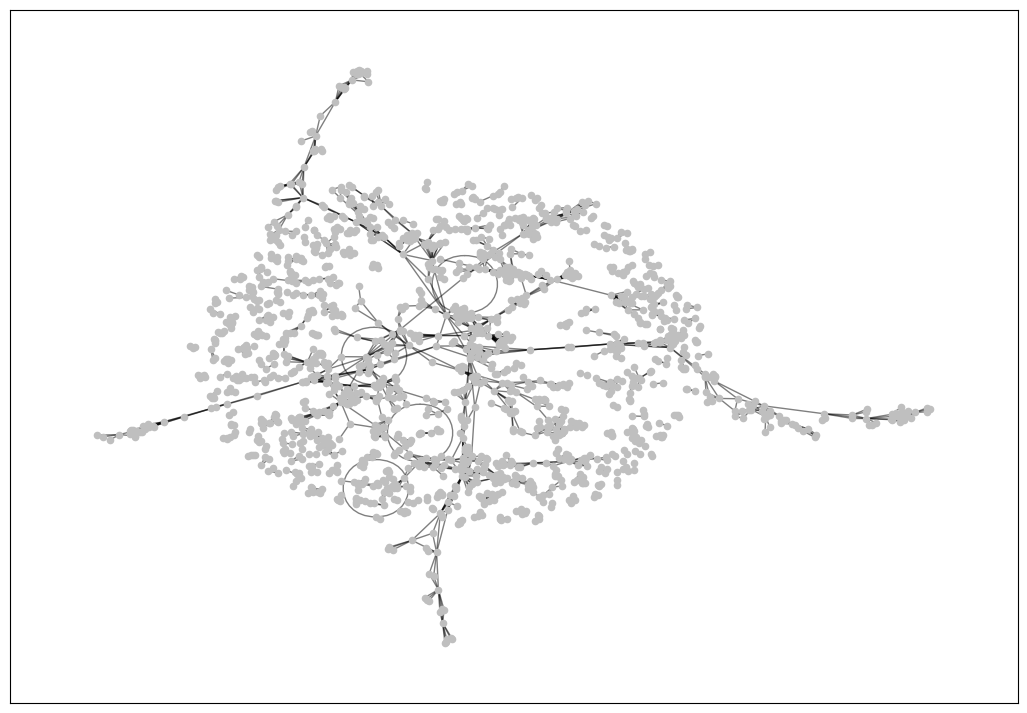

In [3]:
import import_ipynb
import CDP_0_SRC
from itertools import product
import community
import networkx as nx
import numpy as np
import random as rn
import time

import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
N = 1000
k_value = 4
G = CDP_0_SRC.crear_grafo()

def generate_random_partition_with_all_nodes(G, k):
    partition = {node: np.random.randint(1, k+1) for node in G.nodes()}
    return partition

sol_1 = generate_random_partition_with_all_nodes(G, k_value)
sol_2 = generate_random_partition_with_all_nodes(G, k_value)
sol_3 = generate_random_partition_with_all_nodes(G, k_value)

print("SOLUCIÓN 1")
print("LENGTH: ", len(sol_1))
print("Asignación de comunidades a nodos:")
print(sol_1)

print("\nSOLUCIÓN 2")
print("LENGTH: ", len(sol_2))
print("Asignación de comunidades a nodos:")
print(sol_2)

print("\nSOLUCIÓN 3")
print("LENGTH: ", len(sol_3))
print("Asignación de comunidades a nodos:")
print(sol_3)

SOLUCIÓN 1
LENGTH:  1843
Asignación de comunidades a nodos:
{'Nan Li': 4, 'Rong Jin': 4, 'Zhi-Hua Zhou': 3, 'Fajwel Fogel': 1, "Alexandre d'Aspremont": 1, 'Milan Vojnovic': 1, 'Nisheeth Srivastava': 1, 'Ed Vul': 3, 'Paul R. Schrater': 1, 'Sewoong Oh': 4, 'Devavrat Shah': 3, 'Siu On Chan': 1, 'Ilias Diakonikolas': 2, 'Rocco A. Servedio': 1, 'Xiaorui Sun': 3, 'Aaron van den Oord': 3, 'Benjamin Schrauwen': 3, 'Robert A. Vandermeulen': 4, 'Clayton Scott': 3, 'Qiang Liu': 4, 'Alexander T. Ihler': 4, 'Joseph G. Makin': 3, 'Philip N. Sabes': 4, 'Isabel Valera': 4, 'Zoubin Ghahramani': 1, 'Kumar Dubey': 4, 'Qirong Ho': 3, 'Sinead A. Williamson': 1, 'Eric P. Xing': 4, 'Anqi Wu': 4, 'Mijung Park': 3, 'Oluwasanmi O. Koyejo': 3, 'Jonathan W. Pillow': 2, 'Balaji Lakshminarayanan': 2, 'Daniel M. Roy': 1, 'Yee Whye Teh': 2, 'Jason Chang': 1, 'John W. Fisher III': 1, 'Mehmet G?nen': 2, 'Adam A. Margolin': 2, 'Qichao Que': 2, 'Mikhail Belkin': 3, 'Yusu Wang': 3, 'Bo Dai': 3, 'Bo Xie': 2, 'Niao He': 1, 

### Función objetivo


In [5]:
# Función objetivo
def modularidad(G, particion, weight='weight'):
    """
    #Cálculo manual de la modularidad de una partición dada.
    """
    
    m = G.size(weight=weight)
    if m == 0:
        return 0
    
    grados = dict(G.degree(weight=weight))

    Q = 0.0
    for u, v, data in G.edges(data=True):
        w = data.get(weight, 1.0)
        if particion[u] == particion[v]:
            Q += w - (grados[u] * grados[v]) / (2 * m)
    
    fitness = Q / (2 * m)
    return fitness 

## Nuestra implementación
partition1 = sol_1
partition2 = sol_2
partition3 = sol_3

print("Fitness solucion 1: {} ".format(modularidad(G, partition1)))
print("Fitness solucion 2: {} ".format(modularidad(G, partition2)))
print("Fitness solucion 3: {} ".format(modularidad(G, partition3)))

Fitness solucion 1: 0.13271256694587552 
Fitness solucion 2: 0.11843188348091412 
Fitness solucion 3: 0.12268940088610603 


### Función de vecindad

In [6]:
# Función de vecindad
def generate_random_move_neighbors(partition, k, num_vecinos):
    """
    Genera una lista de 'num_vecinos' particiones ÚNICAS.
    Evita devolver candidatos repetidos.
    """
    neighbors = []
    nodes = list(partition.keys())
    
    # Con set evitamos duplicados
    moves_set = set()
    
    max_possible_moves = len(nodes) * (k - 1)
    target_count = min(num_vecinos, max_possible_moves)
    
    while len(moves_set) < target_count:
        u = rn.choice(nodes)
        current_comm = partition[u]
        
        possible_communities = [c for c in range(1, k+1) if c != current_comm]
        
        if possible_communities:
            new_comm = rn.choice(possible_communities)
            
            moves_set.add((u, new_comm))

    for u, new_comm in moves_set:
        new_partition = partition.copy()
        new_partition[u] = new_comm
        neighbors.append(new_partition)
        
    return neighbors

### Criterio de selección

In [7]:
# Criterio de selección
def hill_climbing_steepest(G, initial_partition, k, max_iters, num_vecinos):
    """
    Hill Climbing Steepest Ascent con garantía de vecinos únicos.
    """
    current_partition = initial_partition.copy()
    current_fitness = modularidad(G, current_partition)
    
    # print(f"INICIO -> Fitness inicial: {current_fitness:.6f}")
    
    for i in range(max_iters):
        
        candidates = generate_random_move_neighbors(current_partition, k, num_vecinos)
        
        best_neighbor = None
        best_neighbor_fitness = -1.0
        
        for candidate in candidates:
            fit = modularidad(G, candidate)
            if fit > best_neighbor_fitness:
                best_neighbor_fitness = fit
                best_neighbor = candidate
        
        if best_neighbor_fitness > current_fitness:
            # print(f"   [Iter {i+1}] Mejora (de {len(candidates)} vecinos únicos): {current_fitness:.6f} -> {best_neighbor_fitness:.6f}")
            current_partition = best_neighbor
            current_fitness = best_neighbor_fitness

    # print(f"FIN -> Mejor Fitness final: {current_fitness:.6f}")
    return current_partition, current_fitness


# --- HIPERPARÁMETROS ---
# NUM_ITERACIONES = 50      # número de iteraciones
# VECINOS_POR_PASO = 20 # cantidad de vecinos únicos a evaluar

# print(f"--- Ejecurando HC Steepest (Iter: {NUM_ITERACIONES}, Vecinos Únicos: {VECINOS_POR_PASO}) ---\n")

# print("OPTIMIZANDO SOLUCIÓN 1:")
# best_sol_1, best_fit_1 = hill_climbing_steepest(G, sol_1, k_value, NUM_ITERACIONES, VECINOS_POR_PASO)

# # 1. Registrar el tiempo de inicio
# start_time = time.time() 

# # 2. Ejecutar la función
# best_sol_1, best_fit_1 = hill_climbing_steepest(G, sol_1, k_value, NUM_ITERACIONES, VECINOS_POR_PASO)

# # 3. Registrar el tiempo de finalización
# end_time = time.time() 

# # 4. Calcular la duración
# elapsed_time = end_time - start_time

# print("\n--- RESULTADO DE LA OPTIMIZACIÓN ---")
# print(f"Mejor Modularidad Final: {best_fit_1:.6f}")
# print(f"Tiempo de Ejecución Total: {elapsed_time:.4f} segundos")


### DataFrame con Pandas

In [ ]:
# Hiperparámetros a probar
ITERACIONES_LIST = [10, 50, 100, 500, 1000]
VECINOS_LIST = [10, 20, 30]

results = []
for num_iters, num_vecinos in product(ITERACIONES_LIST, VECINOS_LIST):
    start_time = time.time()
    
    _, best_fit = hill_climbing_steepest(G, sol_1, k_value, num_iters, num_vecinos)
    
    elapsed_time = time.time() - start_time
    
    results.append({
        "Iteraciones": num_iters,
        "Vecinos_por_iteracion": num_vecinos,
        "Fitness_final": best_fit,
        "Tiempo_segundos": elapsed_time
    })

df_results = pd.DataFrame(results)
print(df_results)


KeyboardInterrupt: 

### Diagrama de dispersión

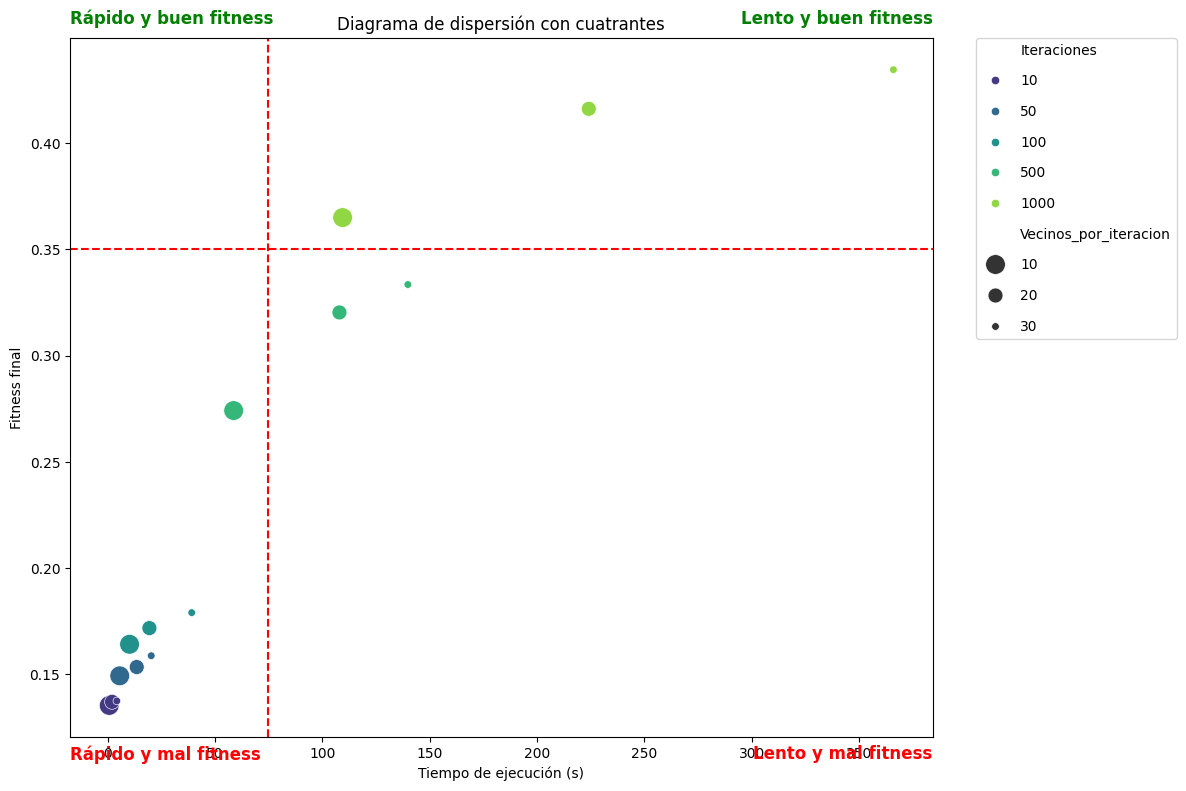

In [10]:
df_results["Iteraciones"] = df_results["Iteraciones"].astype(str)
df_results["Vecinos_por_iteracion"] = df_results["Vecinos_por_iteracion"].astype(str)

tiempo_umbral = df_results["Tiempo_segundos"].mean()
fitness_umbral = 0.35

plt.figure(figsize=(12, 8))

sns.scatterplot(
    data=df_results,
    x="Tiempo_segundos",
    y="Fitness_final",
    hue="Iteraciones",
    size="Vecinos_por_iteracion",
    sizes=(30, 200),
    palette="viridis"
)

# Líneas de cuadrantes
plt.axvline(tiempo_umbral, color='red', linestyle='--')
plt.axhline(fitness_umbral, color='red', linestyle='--')

plt.title("Diagrama de dispersión con cuatrantes")
plt.xlabel("Tiempo de ejecución (s)")
plt.ylabel("Fitness final")

# --- Coordenadas de los límites ---
x_min, x_max = plt.xlim()
y_min, y_max = plt.ylim()

# --- TEXTO FUERA DEL DIAGRAMA (PEGADO A LOS BORDES) ---

# Arriba izquierda (verde)
plt.text(
    x_min, y_max * 1.01,   # un pelín arriba del borde
    "Rápido y buen fitness",
    color="green",
    fontsize=12,
    fontweight="bold",
    ha="left",
    va="bottom"
)

# Abajo izquierda (naranja)
plt.text(
    x_min, y_min * 0.97,
    "Rápido y mal fitness",
    color="red",
    fontsize=12,
    fontweight="bold",
    ha="left",
    va="top"
)

# Abajo derecha (rojo)
plt.text(
    x_max, y_min * 0.97,
    "Lento y mal fitness",
    color="red",
    fontsize=12,
    fontweight="bold",
    ha="right",
    va="top"
)

# Arriba derecha (naranja)
plt.text(
    x_max, y_max * 1.01,
    "Lento y buen fitness",
    color="green",
    fontsize=12,
    fontweight="bold",
    ha="right",
    va="bottom"
)

# Leyenda fuera
plt.legend(
    bbox_to_anchor=(1.05, 1),
    loc='upper left',
    borderaxespad=0.,
    labelspacing=1.2
)

plt.tight_layout()
plt.show()
